In [86]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('600309', start='2020-09-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
161,2020-09-01,68.82,70.46,70.53,68.50,117141.0,600309
162,2020-09-02,70.80,69.70,71.15,68.80,121115.0,600309
163,2020-09-03,70.31,72.00,73.49,69.98,210624.0,600309
164,2020-09-04,70.13,73.70,74.25,69.40,195955.0,600309
165,2020-09-07,73.42,69.08,74.37,67.80,263971.0,600309
...,...,...,...,...,...,...,...
481,2021-12-27,99.40,99.15,99.69,98.57,61599.0,600309
482,2021-12-28,98.58,99.38,99.80,98.38,68757.0,600309
483,2021-12-29,99.80,99.39,100.05,98.20,77945.0,600309
484,2021-12-30,99.39,98.22,99.41,96.65,122423.0,600309


In [87]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
161,68.82,70.46
162,70.80,69.70
163,70.31,72.00
164,70.13,73.70
165,73.42,69.08
...,...,...
481,99.40,99.15
482,98.58,99.38
483,99.80,99.39
484,99.39,98.22


In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.04176394, 0.06977985],
       [0.06744488, 0.05963976],
       [0.06108949, 0.09032688],
       [0.05875486, 0.11300867],
       [0.10142672, 0.05136758],
       [0.04007782, 0.06204136],
       [0.0233463 , 0.00893929],
       [0.01608301, 0.03695797],
       [0.02464332, 0.04162775],
       [0.04513619, 0.06737825],
       [0.06355383, 0.08498999],
       [0.07263294, 0.08338893],
       [0.08560311, 0.09166111],
       [0.07211414, 0.07951968],
       [0.08041505, 0.09299533],
       [0.06614786, 0.03975984],
       [0.03942931, 0.02761841],
       [0.02127108, 0.00747165],
       [0.02996109, 0.        ],
       [0.        , 0.01721147],
       [0.01880674, 0.01747832],
       [0.01193256, 0.0036024 ],
       [0.02075227, 0.04229486],
       [0.04020752, 0.109006  ],
       [0.09857328, 0.13435624],
       [0.13476005, 0.14836558],
       [0.13929961, 0.14062708],
       [0.13488975, 0.14102735],
       [0.14370947, 0.13702468],
       [0.12386511, 0.14503002],
       [0.

In [89]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(243, 2)
(82, 2)


In [90]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:test.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(223, 14, 2)
(223, 1)
(62, 14, 2)
(62, 1)


In [91]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [92]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=True))
# model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=False, dropout=0.1))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 14, 64)            17152     
                                                                 
 lstm_19 (LSTM)              (None, 14, 64)            33024     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [93]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
4/4 [==============================] - 4s 183ms/step - loss: 0.2130 - val_loss: 0.1806
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.1711 - val_loss: 0.1383
Epoch 3/10
4/4 [==============================] - 0s 30ms/step - loss: 0.1161 - val_loss: 0.0829
Epoch 4/10
4/4 [==============================] - 0s 30ms/step - loss: 0.0569 - val_loss: 0.0796
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 0.0575 - val_loss: 0.0724
Epoch 6/10
4/4 [==============================] - 0s 29ms/step - loss: 0.0439 - val_loss: 0.0604
Epoch 7/10
4/4 [==============================] - 0s 29ms/step - loss: 0.0435 - val_loss: 0.0614
Epoch 8/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0432 - val_loss: 0.0597
Epoch 9/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0399 - val_loss: 0.0607
Epoch 10/10
4/4 [==============================] - 0s 32ms/step - loss: 0.0410 - val_loss: 0.0645


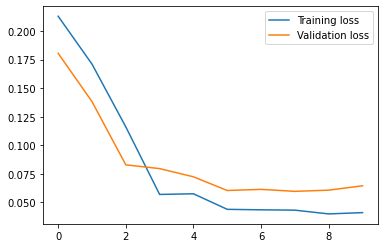

In [94]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [95]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 0s 391ms/step


In [96]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [97]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [98]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48589/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

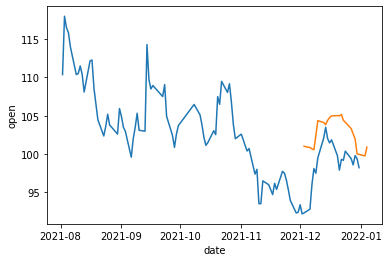

In [99]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [100]:
df.to_csv("600309_WHHX.csv")